The original notebook is [here](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb).

three reasons for including this chapter:
* Any book on Bayesian inference must discuss MCM;
* Knowing the process of MCMC gives you insight into whether your algorithm has converged;
* Understand why we are returned thousands of samples from the posterior as a solution.

## The Bayesian landscape

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distirubtions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on the top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unkowns $p_1$ and $p_2$, and priors for both are $Uni(0, 5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing every point is equally likely).

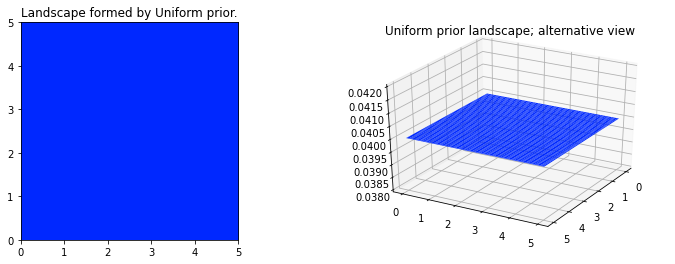

In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform prior.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternative view");

Alternatively, if the two priors are $Exp(3)$ and $Exp(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the prior looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more dark red the color, the more prior probability is assigned to the location. Conversely, areas with darker blue represent that our priors assign very low probability to that location.

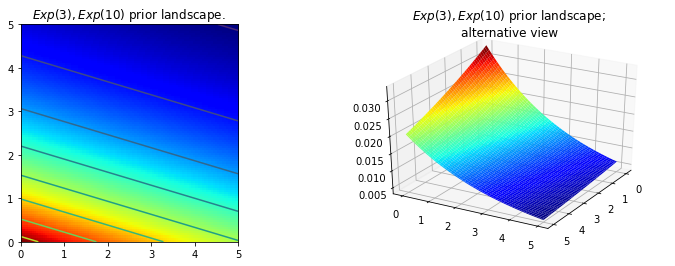

In [3]:
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(y, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

# plt.xlim(0, 5)
# plt.ylim(0, 5)
plt.title("$Exp(3), Exp(10)$ prior landscape.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternative view");

In practice, spaces and surfaces generated by our priors can be much higher dimensional, but our brains can not imagine them well.

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes more mangled or insiginificant compared to the newly formed shape. Less, data, and our original shape is more present. Regardless, the resulting surface describe the *posterior distribution*.

For two dimensions, the data essentially *pushes up* the original surface to make *tall mountains*. Then tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus, in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0, 0) corner would be much higher than mountains that erupt closer to (5, 5), since there is more resistance (low prior probability) near (5, 5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior will be assign there.

Supporse the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape:


In [32]:
# create the observed data

# sample size of data we observed, trying varying this (keep it less than 100;)
N = 100

# the true parameters, but of course we do not see these values ..
lambda_1_true = 1
lambda_2_true = 3

# ... we see the data generated, dependent on the above two values.

data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                         for _x in x]).prod(axis=1)

likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                         for _y in y]).prod(axis=1)

L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 100): [[1 4]
 [2 3]
 [0 3]
 [0 0]
 [1 1]
 [0 2]
 [1 4]
 [1 5]
 [1 1]
 [1 7]
 [1 1]
 [1 3]
 [1 2]
 [0 1]
 [2 4]
 [0 4]
 [0 2]
 [2 4]
 [0 0]
 [1 7]
 [0 7]
 [0 1]
 [1 4]
 [1 5]
 [3 0]
 [2 3]
 [0 2]
 [0 1]
 [3 0]
 [2 6]
 [0 2]
 [1 3]
 [1 2]
 [1 3]
 [0 1]
 [1 3]
 [3 1]
 [0 4]
 [0 1]
 [0 1]
 [2 2]
 [1 3]
 [1 2]
 [1 1]
 [1 3]
 [0 1]
 [1 0]
 [0 3]
 [1 4]
 [2 6]
 [2 4]
 [1 3]
 [1 3]
 [1 1]
 [0 1]
 [1 4]
 [2 2]
 [1 3]
 [0 4]
 [0 5]
 [1 1]
 [0 3]
 [2 1]
 [0 4]
 [1 3]
 [1 3]
 [0 3]
 [1 2]
 [0 2]
 [0 7]
 [2 3]
 [0 3]
 [2 5]
 [2 5]
 [1 1]
 [2 2]
 [0 1]
 [0 0]
 [4 3]
 [1 2]
 [0 6]
 [3 2]
 [0 3]
 [1 3]
 [1 2]
 [1 2]
 [0 1]
 [0 2]
 [0 1]
 [3 2]
 [2 2]
 [0 1]
 [1 4]
 [0 6]
 [1 1]
 [0 7]
 [1 3]
 [1 3]
 [1 1]
 [1 5]]


(0.0, 5.0)

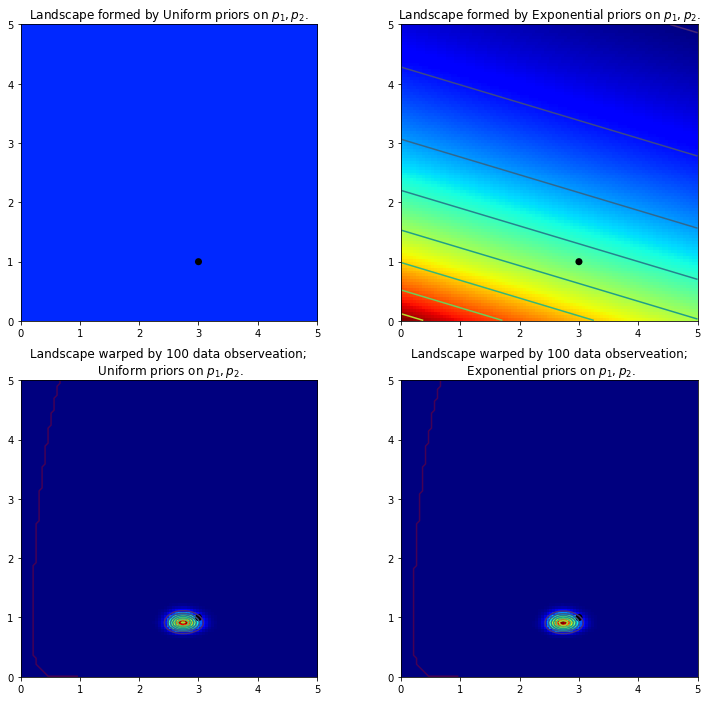

In [33]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observeation;\n Uniform priors on $p_1, p_2$."% N)
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observeation;\n Exponential priors on $p_1, p_2$."% N)
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
plt.xlim(0, 5)
plt.ylim(0, 5)


## Example: Unsupervised Clustering using a Mixture Model

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


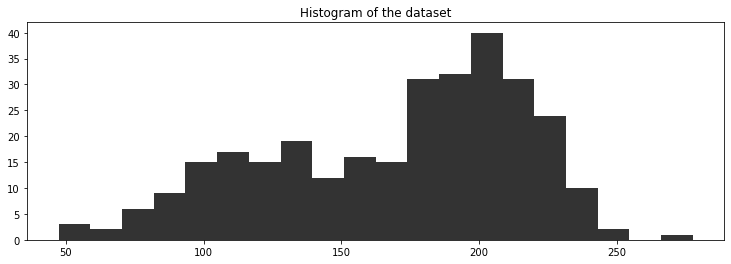

In [34]:
figsize(12.5, 4)
data = np.loadtxt("pymc_data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])
print(data[:10], "...")

The data might be generated by the following algorithm:
1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2.
2. Draw a random variate from a Normal distribution with parameters $\mu_{i}$ and $\sigma_{i}$ where $i$ was chosen in step 1.
3 Repeat.

This algorithm would create a similar effect as the observed dataset, so we choose this as our model.

Denote the Normal distribution $N_0$ and $N_1$. both currently have unknown mean and standard deviation, denoted $\mu_i$ and $\sigma_i$, $i = 0, 1$, respectively. A specific data point can be from either $N_0$ or $N_1$, and we assume that the data point is asigned to $N_0$ with probability $p$.

An appropriate way to assign data points to clusters is to use a PyMC `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is a integer between 0 and $k - 1$ randomly chosen according to the crafted array of probabilites. (in our case $k$ = 2) We do not know what probability of assignment to cluster 1 is, so we create a uniform variable over 0, 1 to model this. Call this `p`. Thus the probability array we enter into the `Categorical` variable is `[p, 1-p]`.

In [36]:
import pymc as pm

p = pm.Uniform("p", 0, 1)

assignment = pm.Categorical("assignment", [p, 1-p], size=data.shape[0])
print("prior assignment, with p = %.2f:" % p.value)
print(assignment.value[:10], "...")

prior assignment, with p = 0.97:
[0 0 0 0 0 0 0 1 0 0] ...


guess the SD of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. that is, $\tau$, the *pricision* of the Normal distribution. 
$$ \tau = \frac{1}{\sigma^2}$$

in PyMC, we can do this in one step by writing:

`taus = 1.0/pm.Uniform("stds", 0, 100, size=2)**2`

Notice that we specified `size=2`: we are modeling both $\tau$s as a single PyMC variable. Note that this does not induce a necessary relationship between the two $\tau$, it's simply for succinctness.

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in this Normal distriubtions. Their priors can be models by a Normal distribution. By looking at the data, we can guess the location of the two centers: around 120 and 190 respectively. Hence, we (the original author) set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_{0, 1} = 10$ (recall we enter the $\tau$ parameter, so enter $1/\sigma^2 = 0.01$ in the PyMC variable)


In [68]:
stds = pm.Uniform("stds", 0, 100, size = 2)
taus = 1.0 / stds ** 2
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

"""
The below determinstic function map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1, 2) arrays 'taus' and 'centers'.
"""

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print("Random assignments: ", assignment.value[:4], "...")
print("Assigned center: ", center_i.value[:4], "...")
print("Assigned precision: ", tau_i.value[:4], "...")

Random assignments:  [1 1 0 0] ...
Assigned center:  [191.86471948 191.86471948 123.04593432 123.04593432] ...
Assigned precision:  [0.00022376 0.00022376 0.0032723  0.0032723 ] ...


In [69]:
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# below we create a model class
model = pm.Model([p, assignment, observations, taus, centers])

PyMC has a MCMC class, `MCMC` in the main namespace of PyMC, that implements the MCMC exploring algorithm. We initializing it by passing in a `Model` instance:

`mcmc = pm.MCMC(model)`

The method for asking the `MCMC` to explore the space is `sample( iterations )`, where `iterations` is the number of steps you wish the algorithm to perform. We try 50000 steps below:

In [70]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

/opt/conda/lib/python3.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 12.3 sec

Below we plot the paths, or "traces", the unknown parameters (centers, precisions, and $p$) have taken so far. The traces can be retrieve using the `trace` method in the `PyMC` object created, which accepts the assigned PyMC variable `name`. For example, `mcmc.trace("centers")` will retrieve a `Trace` object that can be indexed (using `[:]` or `.gettrace()` to retrieve all traces, or fanyc-indexing like `[1000:]).

KeyError: 'stds'

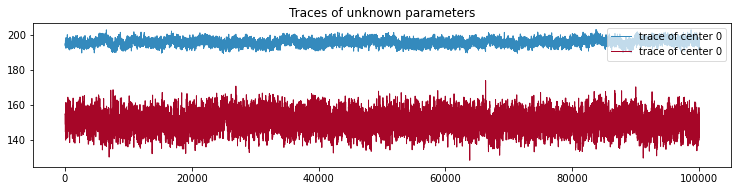

In [81]:
figsize(12.5, 9)
plt.subplot(311)
lw=1

# for pretty colors later
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

center_trace = mcmc.trace("centers")[:]
plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 0", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

# plt.subplot(312)
std_trace = mcmc.trace("stds")[:] # why there is an error message?
plt.plot(std_trace[:, 0], label = "trace of stds of cluster 0", c=colors[0], lw = lw)
plt.plot(std_trace[:, 1], label = "trace of stds of cluster 1", c=colors[1], lw = lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: freq of assignment to cluster 0", color = "#467821", lw=lw)
plt.xlabel("steps")
plt.ylim(0, 1)
plt.legend();

In [61]:
mcmc.trace("p")[:]

array([0.42096054, 0.42096054, 0.42096054, ..., 0.5537237 , 0.5537237 ,
       0.5537237 ])

Notice the following characteristics:
1. The trace converges, not to a single point, but to a *distribution* of possible points. This is *convergence* in a MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus it is a good idea to discard those samples before using the samples for inference. *burn-in* period.
3. The traces appears as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is good and bad. We will discuss it in the Diagonostic section in this chapter.

To achieve further convergence, we will perform more MCMC steps. Starting the MCMC again after it has already been called does not mean starting the entire algorithm over. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are invetigated near the current position), implicitly stored in PyMC variables' `value` attribute. Thus it is fine to halt an MCMC algorithm and inspect its progress, with the intention of starting it up again later. The `value` attributes are not overwritten.

In [73]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 25.4 sec

Text(0.5, 0, 'Steps')

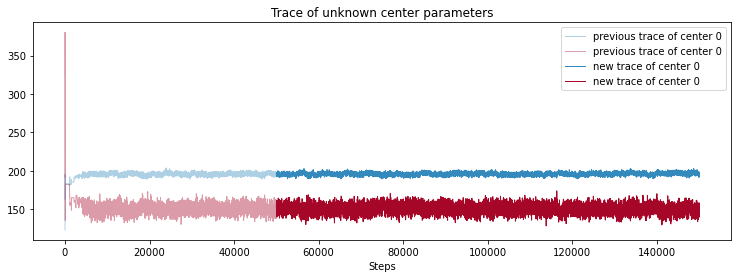

In [79]:
figsize(12.5, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
        lw=lw, alpha=0.4, c=colors[0])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 0",
        lw=lw, alpha=0.4, c=colors[1])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0",
        lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 0",
        lw=lw,  c="#A60628")

plt.title("Trace of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps")

The trace method in the `MCMC` instance has a keyword argument `chain`, that indexes which call to `sample` you would like to be returned. the default for `chain` is -1, which will return the samples from the latest call to `sample`.